In [3]:
!pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.4 MB/s eta 0:00:00


In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
def load_imdb_data():
    from keras.datasets import imdb
    (train_data, train_labels), (test_data, test_labels) = imdb.load_data()

    word_index = imdb.get_word_index()
    reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

    train_reviews = [' '.join([reverse_word_index.get(i - 3, '?') for i in review]) for review in train_data]
    test_reviews = [' '.join([reverse_word_index.get(i - 3, '?') for i in review]) for review in test_data]

    train_df = pd.DataFrame({"review": train_reviews, "label": train_labels})
    test_df = pd.DataFrame({"review": test_reviews, "label": test_labels})

    return pd.concat([train_df, test_df]).reset_index(drop=True)


In [11]:
imdb_data = load_imdb_data()

In [12]:
imdb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  50000 non-null  object
 1   label   50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [13]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)    
    text = text.lower()
    
    words = word_tokenize(text)    
   
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    text = ' '.join(words)
    
    return text

[nltk_data] Downloading package punkt to /Users/apple/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/apple/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/apple/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
imdb_data['review'] = imdb_data['review'].apply(preprocess_text)

In [16]:
keywords = {
  "other": [],
  "funny": [
      "comedy", "humor", "wit", "satire", "parody", "joke", "prank", "playful",
  ],
  "scary": [
      "horror", "terror", "fear", "dread", "shock", "spooky", "haunting", "eerie", "creepy",
      "frightening", "disturbing", "chilling", "macabre", "gory", "bloodcurdling", "terrifying",
      "horrifying", "gothic", "sinister", "malevolent", "ominous", "nightmarish", "supernatural",
      "paranormal", "psychological", "slasher", "zombie", "monster", "demon", "ghost", "witch",
      "vampire", "werewolf", "scream", "jump scare", "horror movie", "haunted house",
      "horror novel", "horror game", "psychological thriller"
  ],
  "dramatic": [
      "drama", "intense", "serious", "emotional", "gripping", "powerful", "poignant",
      "heart-wrenching", "heartfelt", "compelling", "profound", "deep", "meaningful",
      "thought-provoking", "insightful", "touching", "moving", "tragic", "melancholy",
      "sorrowful", "heavy", "profound", "probing", "triumphant", "uplifting", "inspiring",
      "motivational", "empathetic", "sensitive", "emotive", "soulful", "stirring", "resonant",
      "gripping", "engrossing", "character-driven", "emotionally charged", "powerful performances",
      "Oscar-worthy"
  ],
  "action": [
      "action", "adventure", "thrilling", "exciting", "fast-paced", "intense", "dangerous",
      "explosive", "suspenseful", "energetic", "daring", "heroic", "brave", "bold",
      "action-packed", "fight", "shootout", "car chase", "explosion", "stunts", "adrenaline",
      "high-octane", "martial arts", "spy", "espionage", "mission", "rescue", "heist",
      "battle", "war", "combat", "superhero", "villain", "chase scene", "firefight",
      "action hero", "fast and furious", "die hard", "james bond", "bourne identity", "avengers",
      "marvel"
  ],
  "romantic": [
      "romance", "love", "affection", "passion", "intimacy", "sentimental", "heartfelt",
      "adorable", "cute", "charming", "endearing", "sweet", "tender", "loving", "caring",
      "devoted", "committed", "romantic comedy", "chick flick", "heartwarming", "swoon-worthy",
      "chemistry", "romantic gesture", "kiss", "romantic dinner", "flowers", "gifts",
      "love story", "tragic romance", "fairy tale romance", "passionate", "emotional", "sensual",
      "sexy", "intense", "deeply romantic", "unforgettable", "timeless"
  ],
  "sci-fi": [
      "science fiction", "futuristic", "space", "aliens", "robot", "cyborg",
      "virtual reality", "time travel", "artificial intelligence", "nanotechnology",
      "genetic engineering", "dystopian", "post-apocalyptic", "parallel universe",
      "extraterrestrial", "intergalactic", "outer space", "speculative fiction",
      "science fantasy", "flying saucer", "spaceship", "laser gun", "time machine", "android",
      "teleportation", "mutation", "superhuman", "future", "bladerunner", "star wars",
      "star trek", "matrix", "doctor who", "avatar", "the martian"
  ],
  "crime": [
      "crime", "murder", "mystery", "detective", "investigation", "police", "thriller",
      "suspense", "forensic", "serial killer", "organized crime", "mafia", "gang", "robbery",
      "heist", "burglary", "assassination", "corruption", "blackmail", "kidnapping", "hijacking",
      "smuggling", "drug trafficking", "white-collar crime", "justice", "lawyer",
      "courtroom drama", "criminal mastermind", "fbi", "cia", "ncis", "true crime",
      "crime fiction", "crime thriller", "noir", "pulp fiction", "the godfather"
  ],
}



preprocessed_keywords = {
    genre: preprocess_text(' '.join(words))
    for genre, words in keywords.items()
}

In [17]:
def label_data(row):
    label_counts = {label: 0 for label in keywords.keys()}
    label_counts['other'] = 0
    review_text = row["review"].lower()

    for label, words in keywords.items():
        if any(word in review_text for word in words):
            label_counts[label] += 1

    first_genre = max(label_counts, key=label_counts.get)
    first_count = label_counts[first_genre]

    label_counts[first_genre] = 0

    second_genre = max(label_counts, key=label_counts.get)
    second_count = label_counts[second_genre]

    return first_genre

In [18]:
imdb_data['label'] = imdb_data.apply(label_data, axis=1)

In [19]:
imdb_data.drop_duplicates(inplace=True)

In [20]:
imdb_data.to_csv("labeled_data.csv", index=False)

8


<Axes: xlabel='label'>

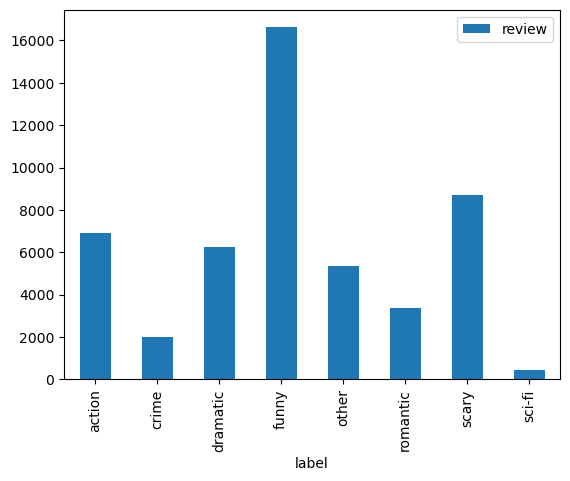

In [21]:
print(len(imdb_data.groupby('label').count()))

imdb_data.groupby('label').count().plot.bar(ylim=0)

We notice that sci-fi and crime are the lowest two, so we remove both from our analysis. Also you can see that funny is dominant in terms of reviews.

In [22]:
keywords = {
      "other": [],
      "funny": [
          "comedy", "humor", "wit", "satire", "parody", "joke", "prank", "playful",
      ],
      "scary": [
          "horror", "terror", "fear", "dread", "shock", "spooky", "haunting", "eerie", "creepy",
          "frightening", "disturbing", "chilling", "macabre", "gory", "bloodcurdling", "terrifying",
          "horrifying", "gothic", "sinister", "malevolent", "ominous", "nightmarish", "supernatural",
          "paranormal", "psychological", "slasher", "zombie", "monster", "demon", "ghost", "witch",
          "vampire", "werewolf", "scream", "jump scare", "horror movie", "haunted house",
          "horror novel", "horror game", "psychological thriller"
      ],
      "dramatic": [
          "drama", "intense", "serious", "emotional", "gripping", "powerful", "poignant",
          "heart-wrenching", "heartfelt", "compelling", "profound", "deep", "meaningful",
          "thought-provoking", "insightful", "touching", "moving", "tragic", "melancholy",
          "sorrowful", "heavy", "profound", "probing", "triumphant", "uplifting", "inspiring",
          "motivational", "empathetic", "sensitive", "emotive", "soulful", "stirring", "resonant",
          "gripping", "engrossing", "character-driven", "emotionally charged", "powerful performances",
          "Oscar-worthy"
      ],
      "action": [
          "action", "adventure", "thrilling", "exciting", "fast-paced", "intense", "dangerous",
          "explosive", "suspenseful", "energetic", "daring", "heroic", "brave", "bold",
          "action-packed", "fight", "shootout", "car chase", "explosion", "stunts", "adrenaline",
          "high-octane", "martial arts", "spy", "espionage", "mission", "rescue", "heist",
          "battle", "war", "combat", "superhero", "villain", "chase scene", "firefight",
          "action hero", "fast and furious", "die hard", "james bond", "bourne identity", "avengers",
          "marvel"
      ],
      "romantic": [
          "romance", "love", "affection", "passion", "intimacy", "sentimental", "heartfelt",
          "adorable", "cute", "charming", "endearing", "sweet", "tender", "loving", "caring",
          "devoted", "committed", "romantic comedy", "chick flick", "heartwarming", "swoon-worthy",
          "chemistry", "romantic gesture", "kiss", "romantic dinner", "flowers", "gifts",
          "love story", "tragic romance", "fairy tale romance", "passionate", "emotional",
          "sensual", "sexy", "intense", "deeply romantic", "unforgettable", "timeless"
      ]
    }

In [23]:
def label_data_filtered(row):
    label_counts = {label: 0 for label in keywords.keys()}
    label_counts['other'] = 0
    review_text = row["review"].lower()

    for label, words in keywords.items():
        if any(word in review_text for word in words):
            label_counts[label] += 1

    first_genre = max(label_counts, key=label_counts.get)
    first_count = label_counts[first_genre]

    label_counts[first_genre] = 0

    second_genre = max(label_counts, key=label_counts.get)
    second_count = label_counts[second_genre]

    return first_genre

6


<Axes: xlabel='label'>

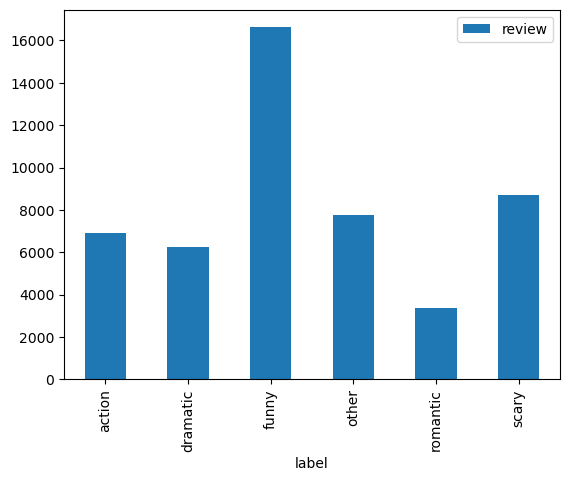

In [24]:
imdb_data['label'] = imdb_data.apply(label_data_filtered, axis=1)

print(len(imdb_data.groupby('label').count()))

imdb_data.groupby('label').count().plot.bar(ylim=0)

This is a much more fair distribution so we will go along with this labeling

In [25]:
train_df = pd.concat([imdb_data, pd.get_dummies(imdb_data['label'], prefix='label')], axis=1)

In [26]:
train_df.drop(columns=['label'], inplace=True)

In [27]:
train_df['review'][0]

'film brilliant casting location scenery story direction everyone really suited part played could imagine robert redford amazing actor director norman father came scottish island loved fact real connection film witty remark throughout film great brilliant much bought film soon released retail would recommend everyone watch fly fishing amazing really cried end sad know say cry film must good definitely also congratulation two little boy played part norman paul brilliant child often left praising list think star play grown big profile whole film child amazing praised done think whole story lovely true someone life shared u'

In [31]:
num_classes = 6

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_df['review'])
sequences = tokenizer.texts_to_sequences(train_df['review'])

max_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_length)

labels = pd.get_dummies(train_df[['label_action', 'label_dramatic', 'label_funny', 'label_other', 'label_romantic','label_scary']])

train_size = int(0.8 * len(train_df))
train_data = padded_sequences[:train_size]
train_labels = labels[:train_size].values
test_data = padded_sequences[train_size:]
test_labels = labels[train_size:].values

early_stopping = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)

model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=32))
model.add(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(train_data, train_labels, validation_split=0.1, epochs=5, batch_size=128, callbacks=[early_stopping])

loss, accuracy = model.evaluate(test_data, test_labels)
print("Test accuracy: {:.2f}%".format(accuracy * 100))

Epoch 1/5
279/279 [==============================] - 654s 2s/step - loss: 1.4225 - accuracy: 0.4223 - val_loss: 1.1299 - val_accuracy: 0.5242
Epoch 2/5
279/279 [==============================] - 654s 2s/step - loss: 1.0342 - accuracy: 0.5590 - val_loss: 0.9296 - val_accuracy: 0.6067
Epoch 3/5
279/279 [==============================] - 637s 2s/step - loss: 0.8877 - accuracy: 0.6127 - val_loss: 0.8321 - val_accuracy: 0.6344
Epoch 4/5
279/279 [==============================] - 636s 2s/step - loss: 0.8163 - accuracy: 0.6508 - val_loss: 0.7594 - val_accuracy: 0.6838
Epoch 5/5
310/310 [==============================] - 40s 129ms/step - loss: 0.8436 - accuracy: 0.6657
Test accuracy: 66.57%


We decided to train our own custom model to expirement more with the possibilites of NLP, hence we adopted a LSTM based model.

In [32]:
# Save the model
model.save('lstm_model_1.h5')

/Users/apple/miniforge3/envs/nlp/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [34]:
from sklearn.metrics import classification_report

# Get the model's output probabilities for each class
probs = model.predict(test_data)

# Get the predicted class for each sample
pred_classes = np.argmax(probs, axis=1)

# Get the true class for each sample
true_classes = np.argmax(test_labels, axis=1)

# Get the classification report for each class
target_names = ['label_action', 'label_dramatic', 'label_funny', 'label_other', 'label_romantic','label_scary']
print(classification_report(true_classes, pred_classes, target_names=target_names))


310/310 [==============================] - 40s 129ms/step
                precision    recall  f1-score   support

  label_action       0.39      0.49      0.43      1335
label_dramatic       0.56      0.27      0.36      1278
   label_funny       0.88      0.94      0.91      3263
   label_other       0.55      0.83      0.66      1640
label_romantic       0.00      0.00      0.00       688
   label_scary       0.72      0.68      0.70      1712

      accuracy                           0.67      9916
     macro avg       0.52      0.54      0.51      9916
  weighted avg       0.63      0.67      0.63      9916



/Users/apple/miniforge3/envs/nlp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/apple/miniforge3/envs/nlp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/apple/miniforge3/envs/nlp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Seeing the results here, we sought improving the results by reducing target genres, hence we randomely selected dramatic and scary to remove them.

In [35]:
keywords = {
    "other": [],
    "funny": ["comedy", "humor", "wit", "satire", "parody", "joke", "prank", "playful", "entertaining"],
    "action": [
        "action", "adventure", "thrilling", "exciting", "fast-paced", "intense", "dangerous", "explosive",
        "suspenseful", "energetic", "daring", "heroic", "brave", "bold", "action-packed", "fight", "shootout",
        "car chase", "explosion", "stunts", "adrenaline", "high-octane", "martial arts", "spy", "espionage",
        "mission", "rescue", "heist", "battle", "war", "combat", "superhero", "villain", "chase scene", "firefight",
        "action hero", "fast and furious", "die hard", "james bond", "bourne identity", "avengers", "marvel"
    ],
    "romantic": [
        "romance", "love", "affection", "passion", "intimacy", "sentimental", "heartfelt", "adorable", "cute",
        "charming", "endearing", "sweet", "tender", "loving", "caring", "devoted", "committed", "romantic comedy",
        "chick flick", "heartwarming", "swoon-worthy", "chemistry", "romantic gesture", "kiss", "romantic dinner",
        "flowers", "gifts", "love story", "tragic romance", "fairy tale romance", "passionate", "emotional", "sensual",
        "sexy", "intense", "deeply romantic", "unforgettable", "timeless"
    ],
}

In [36]:
def label_data_filtered_reduced(row):
    label_counts = {label: 0 for label in keywords.keys()}
    label_counts['other'] = 0
    review_text = row["review"].lower()

    for label, words in keywords.items():
        if any(word in review_text for word in words):
            label_counts[label] += 1

    first_genre = max(label_counts, key=label_counts.get)
    first_count = label_counts[first_genre]

    label_counts[first_genre] = 0

    second_genre = max(label_counts, key=label_counts.get)
    second_count = label_counts[second_genre]

    return first_genre

4


<Axes: xlabel='label'>

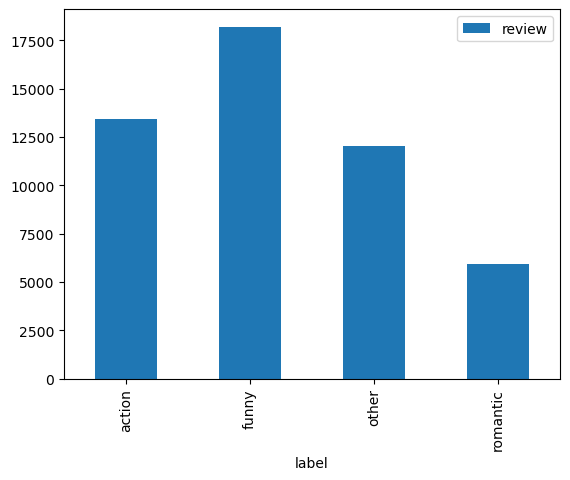

In [37]:
imdb_data['label'] = imdb_data.apply(label_data_filtered_reduced, axis=1)

print(len(imdb_data.groupby('label').count()))

imdb_data.groupby('label').count().plot.bar(ylim=0)

In [38]:
train_df = pd.concat([imdb_data, pd.get_dummies(imdb_data['label'], prefix='label')], axis=1)

In [39]:
from tensorflow.keras.callbacks import EarlyStopping

num_classes = 4

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_df['review'])
sequences = tokenizer.texts_to_sequences(train_df['review'])

max_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_length)

labels = pd.get_dummies(train_df[['label_action', 'label_funny', 'label_other', 'label_romantic']])

train_size = int(0.8 * len(train_df))
train_data = padded_sequences[:train_size]
train_labels = labels[:train_size].values
test_data = padded_sequences[train_size:]
test_labels = labels[train_size:].values

early_stopping = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)

model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=32))
model.add(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(train_data, train_labels, validation_split=0.1, epochs=5, batch_size=128, callbacks=[early_stopping])

loss, accuracy = model.evaluate(test_data, test_labels)
print("Test accuracy: {:.2f}%".format(accuracy * 100))

Epoch 1/5
279/279 [==============================] - 209s 746ms/step - loss: 1.1312 - accuracy: 0.4696 - val_loss: 0.8301 - val_accuracy: 0.5809
Epoch 2/5
279/279 [==============================] - 207s 742ms/step - loss: 0.7797 - accuracy: 0.6176 - val_loss: 0.7517 - val_accuracy: 0.6230
Epoch 3/5
279/279 [==============================] - 208s 747ms/step - loss: 0.7728 - accuracy: 0.6357 - val_loss: 0.7373 - val_accuracy: 0.6462
Epoch 4/5
279/279 [==============================] - 205s 734ms/step - loss: 0.7073 - accuracy: 0.6747 - val_loss: 0.7021 - val_accuracy: 0.6631
Epoch 5/5
310/310 [==============================] - 13s 43ms/step - loss: 0.7149 - accuracy: 0.7189
Test accuracy: 71.89%


In [40]:
from sklearn.metrics import classification_report

# Get the model's output probabilities for each class
probs = model.predict(test_data)

# Get the predicted class for each sample
pred_classes = np.argmax(probs, axis=1)

# Get the true class for each sample
true_classes = np.argmax(test_labels, axis=1)

# Get the classification report for each class
target_names = ['label_action', 'label_funny', 'label_other', 'label_romantic']
print(classification_report(true_classes, pred_classes, target_names=target_names))

310/310 [==============================] - 13s 43ms/step
                precision    recall  f1-score   support

  label_action       0.62      0.70      0.66      2678
   label_funny       0.94      0.97      0.96      3566
   label_other       0.56      0.67      0.61      2473
label_romantic       0.56      0.10      0.16      1199

      accuracy                           0.72      9916
     macro avg       0.67      0.61      0.60      9916
  weighted avg       0.71      0.72      0.69      9916



In [41]:
# save the model
model.save('lstm_model_2(reduced).h5')

/Users/apple/miniforge3/envs/nlp/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
# from the nun movie review good review
review = "I've seen a few stinkers of horrors that certainly deserve 1 or 2 starts, but come on, The Nun deserves better than that. Sure it doesn't have the finesse of The Conjuring films, the plot is a little thin and the scares do rely quite heavily on the tried and tested loud jump scares, but: It has great camera work Very good set pieces and great atmosphere Good acting Great effects And it does make you jump outta your seat If you bear all of that in mind and are not expecting anything else, then you'll have a great time."
review = preprocess_text(review)
sequence = tokenizer.texts_to_sequences([review])
padded_sequence = pad_sequences(sequence, maxlen=max_length)
prob = model.predict(padded_sequence)[0]
pred_class = np.argmax(prob)
print("Predicted class: {}".format(target_names[pred_class]))
print("Confidence score: {:.2f}%".format(prob[pred_class] * 100))


1/1 [==============================] - 0s 44ms/step
Predicted class: label_action
Confidence score: 56.13%


In [43]:
# central intelligence movie review bad review 
review = "Oh really, was this supposed to make us laugh? Sometimes I laughed, but that was more out of ridicule, of the acting, and lack of spontaneity from Johnson and Hart, probably because their characters weren't well designed either. Johnson only has a couple of mimics, like Schwarzenegger, maybe they had the same acting course. I always get the feeling he's telling me : Look here, I'm the Rock and I can be really funny. Well he can't. He's not a natural. Hart, its even worse. He's like a cheap clone of Eddie Murphy, who I couldn't stand either. Alright I admit, I don't like comedies, at least not that kind of brainless comedy. Jokes and funny scenes are so coarse, so primary. It's alright for kids though, and those who remained. Well there must be a lot of them in the USA, or else they would not have raised the budget. So what's a great comedy in this kind of style ? Ruthless People! That was funny, really funny, great characters, great comedians."
review = preprocess_text(review)
sequence = tokenizer.texts_to_sequences([review])
padded_sequence = pad_sequences(sequence, maxlen=max_length)
prob = model.predict(padded_sequence)[0]
pred_class = np.argmax(prob)
print("Predicted class: {}".format(target_names[pred_class]))
print("Confidence score: {:.2f}%".format(prob[pred_class] * 100))

1/1 [==============================] - 0s 40ms/step
Predicted class: label_funny
Confidence score: 93.34%


In [ ]:
# fast & furious movie review bad review
review = "I am a huge fan of the first couple of fast & furious movies, I have watched them multiple times and really loved many things about them. But even I hated this movie while going in with low expectations. 1) the plot is almost non-existent 2) the action is so unrealistic that it's pretty much a sci-fi movie.. the only good thing about this movie is briefly seeing the old cast and even that wears off. The Rio race vibe was good but lasted very short, it's not worth watching the movie for. Honestly absolutely freaking horrible, started looking at my watch and just wanted to get out that cinema. My rating of 4 feels generous."
review = preprocess_text(review)
sequence = tokenizer.texts_to_sequences([review])
padded_sequence = pad_sequences(sequence, maxlen=max_length)
prob = model.predict(padded_sequence)[0]
pred_class = np.argmax(prob)
print("Predicted class: {}".format(target_names[pred_class]))
print("Confidence score: {:.2f}%".format(prob[pred_class] * 100))

1/1 [==============================] - 0s 76ms/step
Predicted class: label_action
Confidence score: 79.93%


In [44]:
# The fault in our stars movie review good review
review = "One of the best romance movies I have ever seen and one of my favorite movies that I have ever seen. I loved the book and I loved the movie even more. The writing, plot, story, and screenplay were fantastic. Shaileen Woodley and Ansel Elgort's performances in the film as Hazel and Augustus were spectacular. The Fault in Our Stars is gorgeous, funny and sad at the same time and it shows true love can be found no matter what. Loved it so much."
review = preprocess_text(review)
sequence = tokenizer.texts_to_sequences([review])
padded_sequence = pad_sequences(sequence, maxlen=max_length)
prob = model.predict(padded_sequence)[0]
pred_class = np.argmax(prob)
print("Predicted class: {}".format(target_names[pred_class]))
print("Confidence score: {:.2f}%".format(prob[pred_class] * 100))

1/1 [==============================] - 0s 41ms/step
Predicted class: label_romantic
Confidence score: 48.88%


In [45]:
# The greatest show man movie review good review
review = "This was the perfect family night movie. I loved the music although at first I thought it would be annoying. I enjoyed the scenes and the costumes and everything about this magical film. I would definitely watch it again."
review = preprocess_text(review)
sequence = tokenizer.texts_to_sequences([review])
padded_sequence = pad_sequences(sequence, maxlen=max_length)
prob = model.predict(padded_sequence)[0]
pred_class = np.argmax(prob)
print("Predicted class: {}".format(target_names[pred_class]))
print("Confidence score: {:.2f}%".format(prob[pred_class] * 100))

1/1 [==============================] - 0s 37ms/step
Predicted class: label_other
Confidence score: 55.66%


In [50]:
from tensorflow.keras.models import load_model

# Load the model from the .h5 file
model_1 = load_model('lstm_model_1.h5')
model_2 = load_model('lstm_model_2(reduced).h5')

310/310 [==============================] - 41s 130ms/step


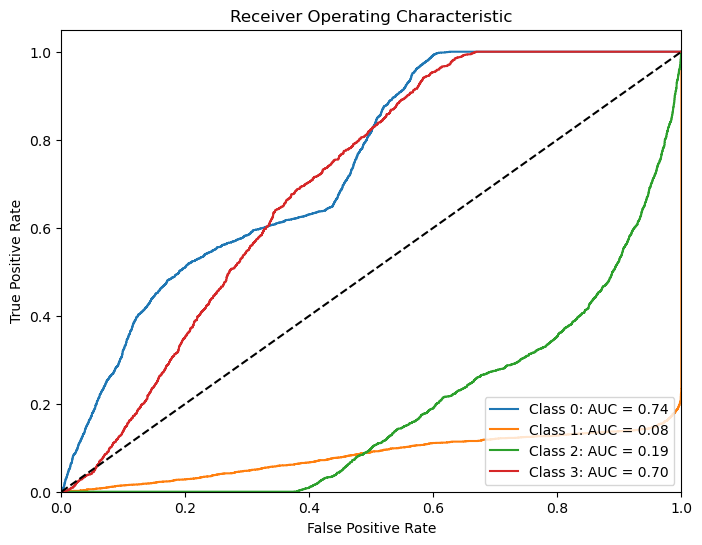

In [47]:
from sklearn.metrics import roc_curve, auc

y_pred_prob = model_1.predict(test_data)

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(test_labels[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='Class {}: AUC = {:.2f}'.format(i, roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()







310/310 [==============================] - 13s 43ms/step


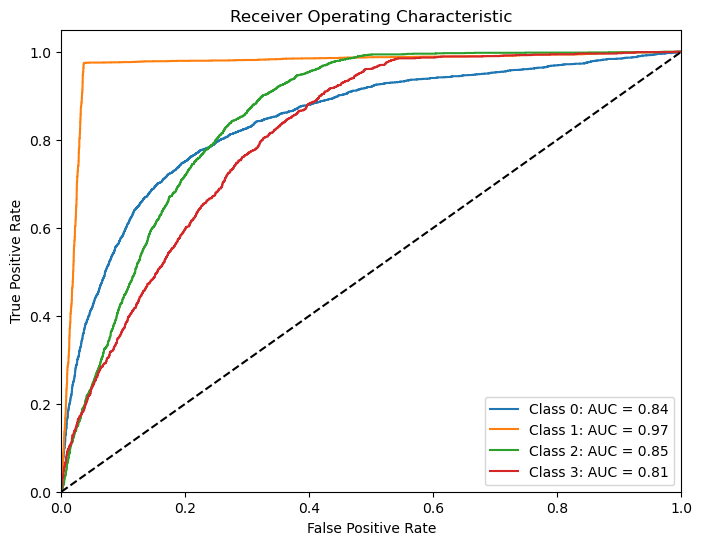

In [51]:
from sklearn.metrics import roc_curve, auc

y_pred_prob = model_2.predict(test_data)

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(test_labels[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='Class {}: AUC = {:.2f}'.format(i, roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()